In [1]:
import pandas as pd
import numpy as np
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

In [2]:
# plot this data 
# CUPS;Fecha;Hora;AE_kWh;AS_KWh;AE_AUTOCONS_kWh;REAL/ESTIMADO,
# ES0031405462253006LB0F;01/05/2022;1;0,047;;;R

# read the data
df = pd.read_csv('marco_data.csv', sep=';', decimal=',', thousands='.', parse_dates=[1], dayfirst=True)



In [3]:
df.columns

Index(['CUPS', 'Fecha', 'Hora', 'AE_kWh', 'AS_KWh', 'AE_AUTOCONS_kWh',
       'REAL/ESTIMADO,'],
      dtype='object')

<Axes: title={'center': 'AE_kWh'}, xlabel='Fecha'>

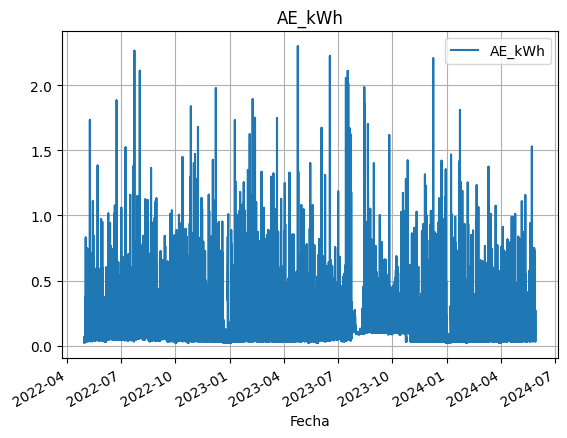

In [4]:

# plot the data
df.plot(x='Fecha', y='AE_kWh', kind='line', title='AE_kWh', grid=True)
# df.plot(x='Fecha', y='AS_KWh', kind='line', title='AS_KWh', grid=True)
# df.plot(x='Fecha', y='AE_AUTOCONS_kWh', kind='line', title='AE_AUTOCONS_kWh', grid=True)
# df.plot(x='Fecha', y='REAL/ESTIMADO,', kind='line', title='REAL/ESTIMADO', grid=True)

In [5]:
df['AE_kWh']

0        0.047
1        0.040
2        0.063
3        0.030
4        0.058
         ...  
18259      NaN
18260      NaN
18261      NaN
18262      NaN
18263      NaN
Name: AE_kWh, Length: 18264, dtype: float64

In [6]:
# count nan
df['AE_kWh'].isna().sum()

24

In [7]:
# remove nan
df = df.dropna(subset=['AE_kWh'])
dataset = df['AE_kWh']

# dataset = dataset[:int(len(dataset)*0.2)]
train_dataset_80 = dataset[:int(len(dataset)*0.8)]
test_dataset_20 = dataset[int(len(dataset)*0.8):]

In [8]:
def generate_mock_data(seq_length=50, num_samples=1000):
    X, Y = [], []
    for _ in range(num_samples):
        seq = np.sin(np.linspace(0, 10, seq_length)) + np.random.normal(0, 0.1, seq_length)
        X.append(seq[:-1])  # Input sequence
        Y.append(seq[1:])   # Target sequence (shifted)
    return np.array(X), np.array(Y)

def generate_data_shift(dataset, seq_length=10):
    X, Y = [], []
    for i in range(len(dataset) - seq_length):
        X.append(dataset[i:i+seq_length])
        Y.append(dataset[i+1:i+seq_length+1])
    return np.array(X), np.array(Y)

# generate data windows without intersection
def generate_data_windows(dataset, seq_length=10):
    X, Y = [], []
    for i in range(0, len(dataset) - seq_length, seq_length):
        X.append(dataset[i:i+seq_length])
        Y.append(dataset[i+1:i+seq_length+1])
    return np.array(X), np.array(Y)

In [9]:
X_train, Y_train = generate_data_windows(train_dataset_80, seq_length=50)
X_test, Y_test = generate_data_windows(test_dataset_20, seq_length=50)

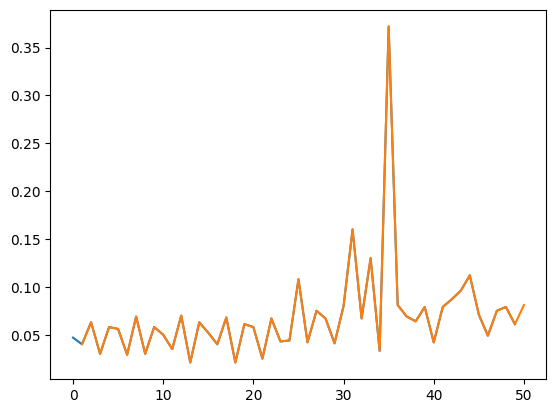

In [10]:
import matplotlib.pyplot as plt


plt.plot(X_train[0], label='Input sequence')
plt.plot(np.arange(1, 51), Y_train[0], label='Target sequence')

In [11]:
reservoir = Reservoir(units=200, lr=0.9, input_scaling=0.5, sr=1.2, seed=42)
readout = Ridge(ridge=1e-6)  # Ridge regression for output mapping


In [12]:
reservoir_states = reservoir.run(X_train)  # Run input through reservoir
readout.fit(reservoir_states, Y_train)  # Train readout layer


Running Reservoir-0: 100%|██████████| 2868/2868 [00:00<00:00, 23588.13it/s]


'Ridge-0': Ridge(ridge=1e-06, input_bias=True, in=200, out=50)

In [13]:
def predict_sequence(X_input, steps=10):
    pred_seq = []
    current_input = X_input

    for _ in range(steps):
        res_state = reservoir.run(current_input.reshape(1, -1))
        pred = readout.run(res_state)
        pred_seq.append(pred.flatten()[-1])  # Append last value of prediction
        current_input = np.append(current_input[1:], pred.flatten()[-1])  # Shift input

    return np.array(pred_seq)

predictions = predict_sequence(X_test[0])
all_predictions = np.array([predict_sequence(X_test[i]) for i in range(len(X_test))])


Running Ridge-0: 100%|██████████| 1/1 [00:00<00:00, 3813.00it/s]


In [16]:
Y_test.shape, all_predictions.shape

((680, 50), (680, 10))

In [15]:
# calculate the error
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Y_test, all_predictions)
print(f'Mean Squared Error: {mse}')

ValueError: y_true and y_pred have different number of output (50!=10)

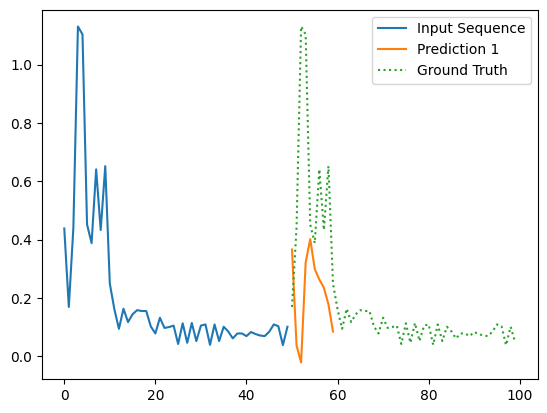

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(len(X_test[0])), X_test[0], label="Input Sequence")
# plot prediction for first sequence
plt.plot(range(len(X_test[0]), len(X_test[0]) + len(predictions)), predictions, label="Prediction 1")
# plot all predictions
# for i, pred in enumerate(all_predictions):
#     plt.plot(range(len(X_test[i]), len(X_test[i]) + len(pred)), pred, label=f"Prediction {i+1}")

# plot ground truth
plt.plot(range(len(X_test[0]), len(X_test[0]) + len(Y_test[0])), Y_test[0], label="Ground Truth", linestyle="dotted")

plt.legend()
plt.show()


Running Ridge-0: 100%|██████████| 1/1 [00:00<00:00, 3061.54it/s]

[[ 3.15707778e-01  7.07858715e-01  1.30684858e+00  1.05245720e+00
   5.90318269e-01  5.70282238e-01  7.04053290e-01  6.40415130e-01
   3.19507080e-01 -7.84142655e-02  3.18181146e-01 -3.19874225e-02
   1.84699722e-01  1.83475260e-01  1.79856547e-01  2.83237150e-01
   8.65648622e-02  1.26920200e-02  2.80749026e-02  9.24352263e-02
   5.55005016e-02  4.09558589e-02  1.29660753e-01  3.91085608e-02
   4.76461077e-02  4.60301408e-02 -1.58192217e-02  4.83584835e-02
  -4.57476846e-02  1.50825647e-01  1.06013025e-01  2.28637726e-01
   1.65767064e-01  8.16453228e-02  1.04997250e-01  1.18233543e-01
  -6.32512359e-02  3.74689146e-02  5.60121653e-02  6.07977849e-02
   8.86668011e-02  1.28776244e-01  7.13558847e-02  9.52248460e-02
  -5.27001344e-02  1.13664371e-01  8.90442155e-04  2.06680643e-01
   1.06574755e-01  3.94468123e-01]]
[0.169 0.441 1.131 1.104 0.452 0.388 0.641 0.433 0.652 0.249 0.161 0.094
 0.163 0.117 0.144 0.158 0.155 0.155 0.102 0.078 0.132 0.097 0.1   0.105
 0.042 0.113 0.046 0.114 0

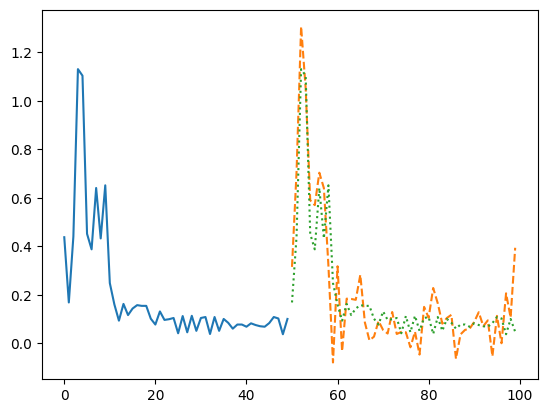

In [31]:
res_states = reservoir.run(X_test[0])
pred = readout.run(res_states)
pred.shape

print(pred)
print(Y_test[0])

# plot pred and ground truth
plt.plot(range(len(X_test[0])), X_test[0], label="Input Sequence")
plt.plot(range(len(X_test[0]), len(X_test[0]) + len(pred[0]), 1), pred[0], label="Prediction", linestyle="dashed")
plt.plot(range(len(X_test[0]), len(X_test[0]) + len(Y_test[0]), 1), Y_test[0], label="Ground Truth", linestyle="dotted")